# Scrapbook for Home-depot Question

## Imports

In [1]:
# Data Wrangling
import numpy as np
import pandas as pd

In [2]:
# Plotting
import matplotlib.pyplot as plot
import seaborn as sns
%matplotlib inline

In [64]:
# Misc
import os
import re
from pprint import pprint as pp

In [181]:
# Machine Learning
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Config

In [51]:
data_path = "./data/"

In [142]:
stemmer = SnowballStemmer('english')

## Functions

In [140]:
def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

In [143]:
def str_common_word(str1, str2):
    return sum(int(str2.find(word)>=0) for word in str1.split())

In [192]:
def process_data(df):
    df['product_title'] = df['product_title'].apply(lambda x: str_stemmer(x))
    df['search_term'] = df['search_term'].apply(lambda x: str_stemmer(x))
    df['product_description'] = df['product_description'].apply(lambda x: str_stemmer(x))
    df['query_len'] = df['search_term'].apply(lambda x: len(x.split()))
    df['product_info'] = df['search_term']+"\t"+df['product_title']+"\t"+df['product_description']
    df['word_in_title'] = df['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
    df['word_in_description'] = df['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))
    return df

## Import data

In [52]:
csvs = [f for f in os.listdir(data_path) if re.search(".csv$", f)]

In [53]:
csvs

['test.csv',
 'train.csv',
 'product_descriptions.csv',
 'attributes.csv',
 'sample_submission.csv']

In [58]:
data_dict = {}
for csv in csvs:
    data_dict[csv.split()[0]] = pd.read_csv(data_path+csv, encoding='latin1')

In [60]:
test_df = data_dict[csvs[0]]
train_df = data_dict[csvs[1]]
prod_desc = data_dict[csvs[2]]
attributes = data_dict[csvs[3]]
sample_sub = data_dict[csvs[4]]

## High-Level Overview

### Test Data

In [68]:
test_df.head()

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


In [69]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 4 columns):
id               166693 non-null int64
product_uid      166693 non-null int64
product_title    166693 non-null object
search_term      166693 non-null object
dtypes: int64(2), object(2)
memory usage: 5.1+ MB


### Train Data

In [70]:
train_df.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [71]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
id               74067 non-null int64
product_uid      74067 non-null int64
product_title    74067 non-null object
search_term      74067 non-null object
relevance        74067 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB


### Sample Sub

In [72]:
sample_sub.head()

,id,relevance
0,1,1
1,4,1
2,5,1
3,6,1
4,7,1


In [73]:
sample_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 2 columns):
id           166693 non-null int64
relevance    166693 non-null int64
dtypes: int64(2)
memory usage: 2.5 MB


### Attributes of Products

In [75]:
attributes.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90Â° connectio...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


In [76]:
attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2044803 entries, 0 to 2044802
Data columns (total 3 columns):
product_uid    float64
name           object
value          object
dtypes: float64(1), object(2)
memory usage: 46.8+ MB


### Product Descriptions

In [77]:
prod_desc.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [78]:
prod_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124428 entries, 0 to 124427
Data columns (total 2 columns):
product_uid            124428 non-null int64
product_description    124428 non-null object
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


## Investigation

In [110]:
attr = attributes.dropna(how='all')

In [114]:
attr.loc[:,'product_uid'] = attr.loc[:,'product_uid'].apply(lambda x: int(x))

/Users/alastairhamilton/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [115]:
attr.head()

,product_uid,name,value
0,100001,Bullet01,Versatile connector for various 90Â° connectio...
1,100001,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001,Bullet03,Help ensure joints are consistently straight a...
3,100001,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001,Bullet05,Made from 12-Gauge steel


Let start by using moomin's sklearn random forest kernel on Kaggle to get a starting point

In [189]:
df_train = pd.merge(train_df, prod_desc, how='left', on='product_uid').drop('id', axis=1)
df_test = pd.merge(test_df, prod_desc, how='left', on='product_uid').drop('id', axis=1)

In [194]:
df_train.head()

,product_uid,product_title,search_term,relevance,product_description,query_len,product_info,word_in_title,word_in_description
0,100001,simpson strong-ti 12-gaug angl,angl bracket,3.00,"not onli do angl make joint stronger, they als...",2,angl bracket\tsimpson strong-ti 12-gaug angl\t...,1,1
1,100001,simpson strong-ti 12-gaug angl,l bracket,2.50,"not onli do angl make joint stronger, they als...",2,l bracket\tsimpson strong-ti 12-gaug angl\tnot...,1,1
2,100002,behr premium textur deckov 1-gal. #sc-141 tugb...,deck over,3.00,behr premium textur deckov is an innov solid c...,2,deck over\tbehr premium textur deckov 1-gal. #...,1,1
3,100005,delta vero 1-handl shower onli faucet trim kit...,rain shower head,2.33,updat your bathroom with the delta vero single...,3,rain shower head\tdelta vero 1-handl shower on...,1,1
4,100005,delta vero 1-handl shower onli faucet trim kit...,shower onli faucet,2.67,updat your bathroom with the delta vero single...,3,shower onli faucet\tdelta vero 1-handl shower ...,3,2


In [190]:
# df_train = process_data(df_train)
# df_test = process_data(df_test)

In [191]:
# df_train.to_csv('df_train.csv', encoding='utf-8')
# df_test.to_csv('df_test.csv', encoding='utf-8')
df_train = pd.read_csv('df_train.csv').drop(['search_term','product_title','product_description','product_info'],axis=1)
df_test = pd.read_csv('df_test.csv').drop(['search_term','product_title','product_description','product_info'],axis=1)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['product_uid','relevance'], axis=1), df_train['relevance'], test_size=0.33, random_state=42)

In [182]:
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [184]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.39326997308706296
MSE: 0.23660484818601166
RMSE: 0.4864204438405233


/Users/alastairhamilton/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


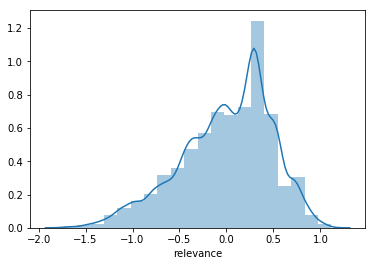

In [186]:
sns.distplot((y_test-y_pred),bins=20)

Okay. That was decent. However, let's work on this and do better!

Attributes wasn't used...I think there must be something here. Also only stems were taken...can we not extract keywords?